In [1]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras import backend as K
from IPython.display import clear_output

import pydicom
from skimage.io import imread
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

# Set neural network hyperparameters
N_EPOCHS = 100
LEARN_R = 5e-4
BATCH_SZ = 4
SZ = 128

In [2]:
def dice_coeff(groundtruth_mask, pred_mask): #Function to calculate Dice coefficient
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return dice
def precision_score_(groundtruth_mask, pred_mask): #Function to calculate Precision
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return precision
def recall_score_(groundtruth_mask, pred_mask): #Function to calculate Recall
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return recall
def iou(groundtruth_mask, pred_mask): #Function to calculate Jaccard index
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return iou

In [3]:
# Normalize image using 5th and 95th percentile values
def im_normalize(img):
    im_min, im_max = np.percentile(img,[5,95])
    return np.clip(np.array((img-im_min)/(im_max-im_min), dtype=np.float32), 0.0, 1.0)

In [4]:
# Perform image cropping from center
def crop_center(img, lbl, crx, cry):
    y, x = img.shape
    sx = x//2-(crx//2)
    sy = y//2-(cry//2)
    return img[sy:sy+cry,sx:sx+crx], lbl[sy:sy+cry,sx:sx+crx]

In [5]:
# Define loss function and evaluation metric

eps = 1e-5

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + eps) / (K.sum(y_true_f) + K.sum(y_pred_f) + eps)

def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

In [6]:
# UNet neural network model definition
def get_unet():
    inputs = Input((SZ, SZ, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=LEARN_R), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [7]:
# Load model and weights
model = get_unet()
model.load_weights(os.path.join('trained_models', 'trained_unet.h5'))

In [8]:
# Display MR image along with label
def display_im_label(img, lbl, titlef=""):

    mask = np.ma.masked_where(lbl == 0, lbl)
    clear_output(wait=True) # clear figure
    plt.figure(figsize=(5,5))
    # show MR image
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, alpha=0.3)
    plt.axis('off')

    #plt.pause(0.01)  

In [9]:
# assign test data location
test_dir = os.path.join('lv_deeplearning','test')
fimgs = glob.glob(os.path.join(test_dir, '*.dcm'))
gt = glob.glob(os.path.join(test_dir,'GT', '*.png'))

In [10]:
# create empty evaluation arrays for 20 test data
prec = np.zeros(20)
recall = np.zeros(20)
dice = np.zeros(20)
jacc = np.zeros(20)

C:\Users\Kiarash\AppData\Local\Temp\ipykernel_39836\1701990384.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


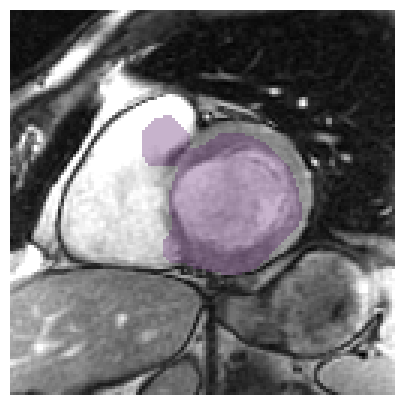

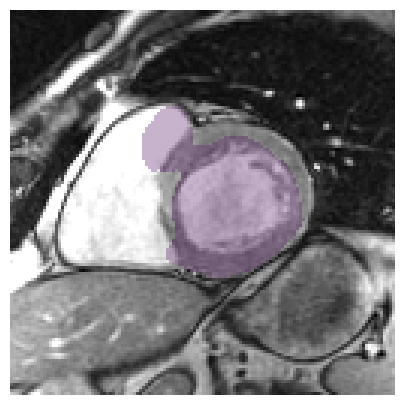

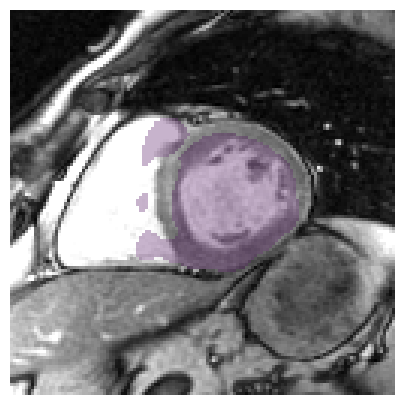

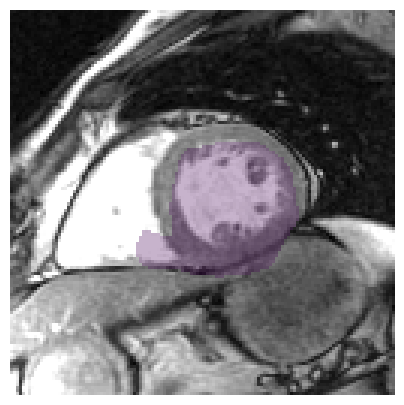

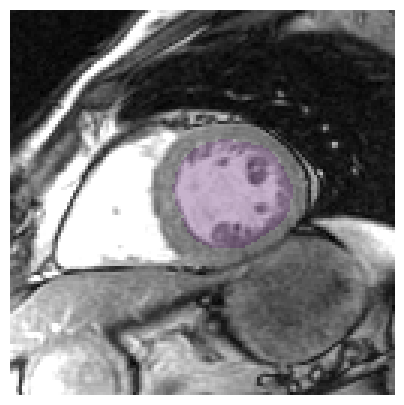

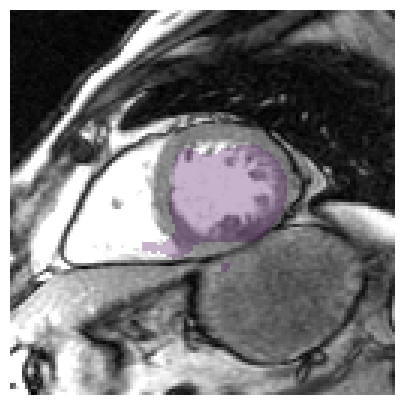

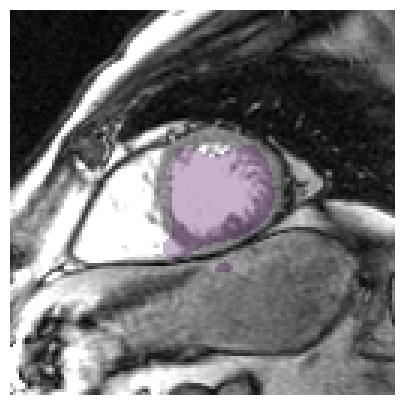

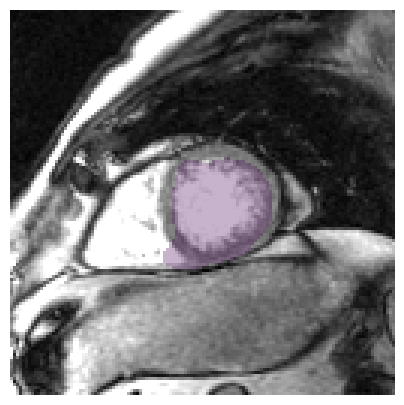

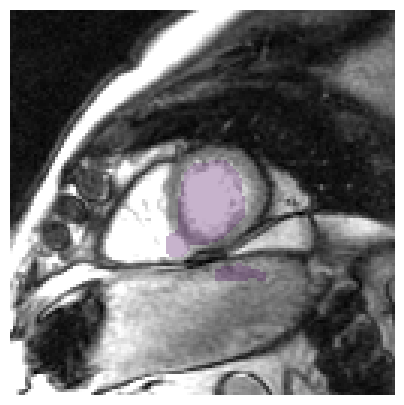

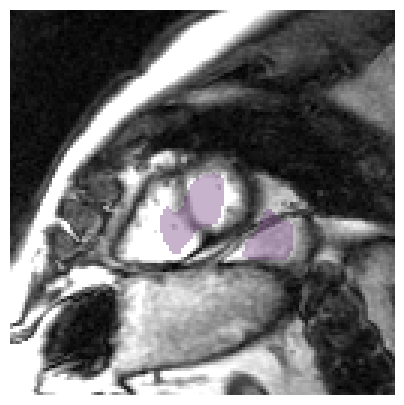

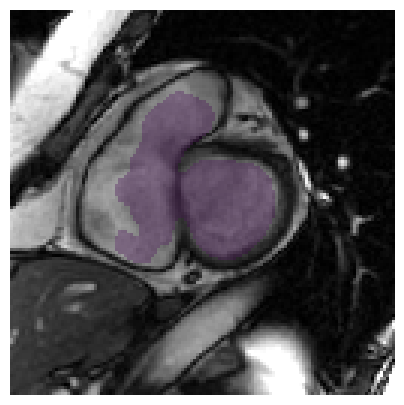

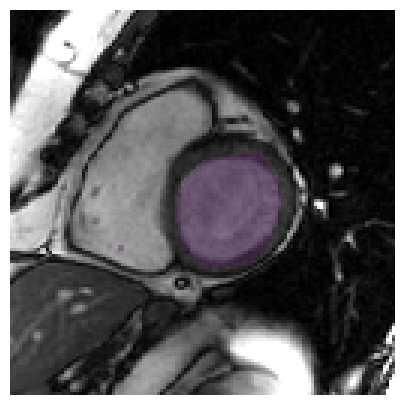

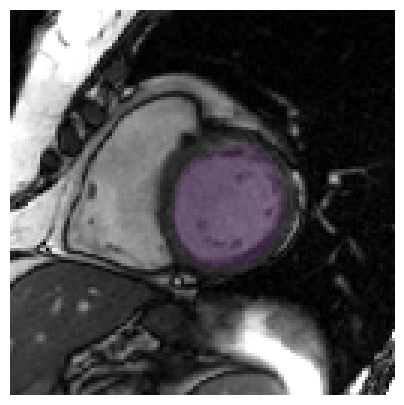

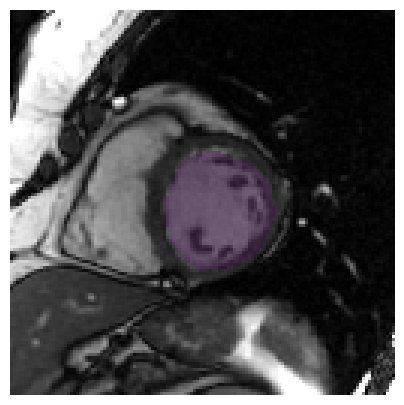

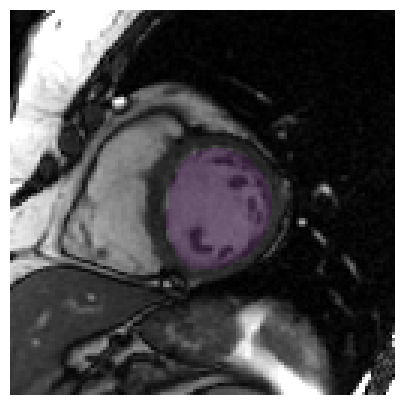

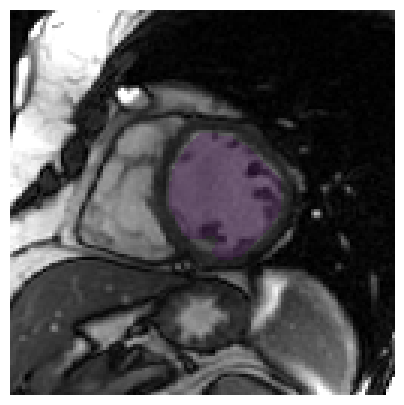

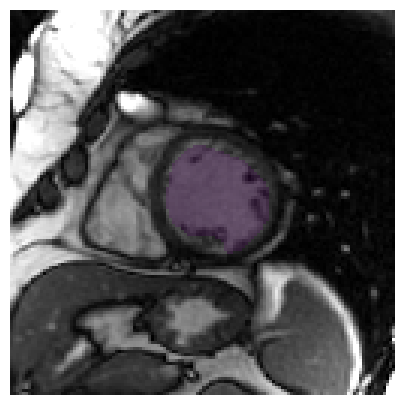

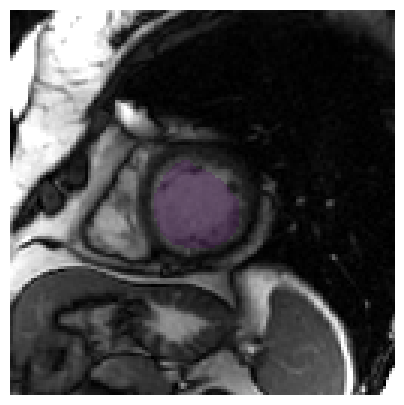

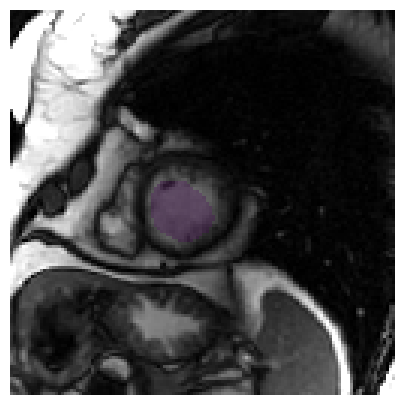

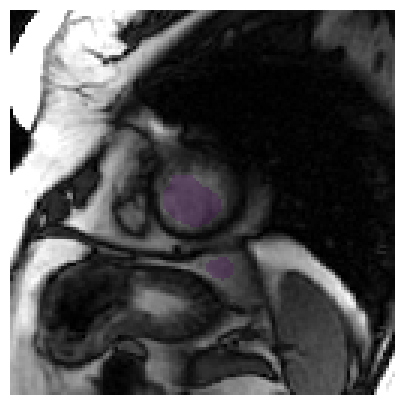

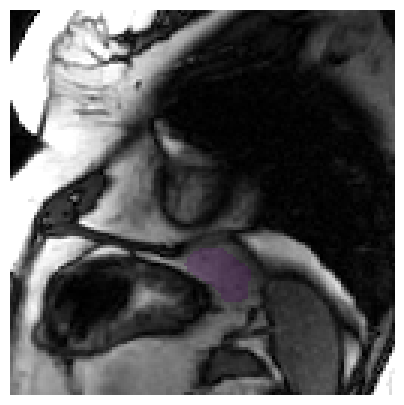

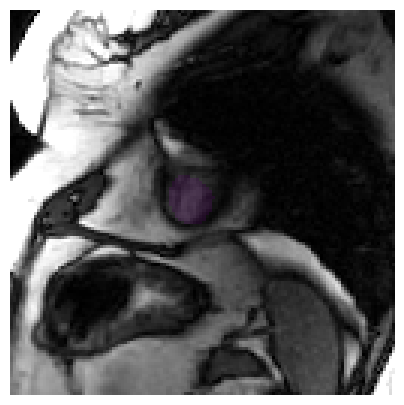

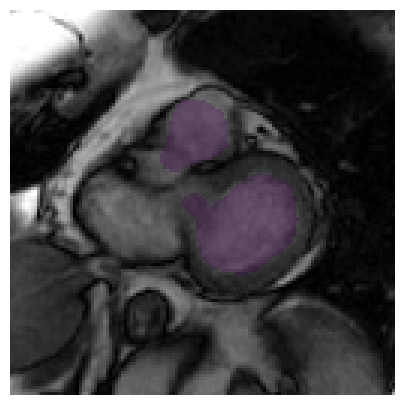

In [11]:
i = 0
# Iterate over test image and predict segmentation label and calculate evaluation metrics
for fim in fimgs:
    ds = pydicom.read_file(fim)
    img = ds.pixel_array
    mask = imread(gt[i])
    

    img = im_normalize(img)
    img, _ = crop_center(img, img, SZ, SZ)
    mask, _ = crop_center(mask, mask, SZ, SZ)

    test_img = img[np.newaxis, :, :, np.newaxis]
    lbl = model.predict(test_img, verbose=0).round().astype('bool')
    mask = mask.round().astype('bool')
    
    
    # Comment this line when computing approximate runtime
    display_im_label(img, lbl[0,:,:,0])
    if i == 3 or i == 12 or i == 18:
        display_im_label(img, mask)

    # calculate each evaluation metric
    # Comment this line when computing approximate runtime
    prec[i] = precision_score_(mask,lbl[0,:,:,0])
    recall[i] = recall_score_(mask,lbl[0,:,:,0])
    dice[i] = dice_coeff(mask,lbl[0,:,:,0])
    jacc[i] = iou(mask,lbl[0,:,:,0])
    
    i += 1


In [33]:
#print mean and std for each evaluation metric 
print("precision mean and std:", np.mean(prec),", ", np.std(prec))
print("recall mean and std:", np.mean(recall),", ", np.std(recall))
print("dice mean and std:", np.mean(dice),", ", np.std(dice))
print("jaccard index mean and std:", np.mean(jacc),", ", np.std(jacc))

precision mean and std: 0.7194301665263798 ,  0.254018103592966
recall mean and std: 0.8272452670554818 ,  0.23980812557875017
dice mean and std: 0.7495781053678072 ,  0.21692728627096827
jaccard index mean and std: 0.6372353960732251 ,  0.22327068940092357


In [12]:
#for finding best, worst and 50th percentile samples
print(np.sort(dice))

array([0.        , 0.41716329, 0.5593985 , 0.6572238 , 0.72965517,
       0.73625219, 0.73722871, 0.75144509, 0.76206323, 0.76442308,
       0.77314488, 0.84548944, 0.84780158, 0.86136524, 0.86329386,
       0.90083507, 0.93071001, 0.94403893, 0.94413646, 0.96589359])